In [3]:
import gymnasium as gym
import cv2
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
import numpy as np
from util import *
import random
# Create the environment with the grayscale observation type
env = gym.make("ALE/Assault-v5", obs_type="grayscale")
obs, info = env.reset()

In [16]:
#make sure can't resize to much
def get_iou_score(obj1, obj2):
    """
    Calculate the NCC score between two objects, with zero padding to make their sizes match.
    """
    # Get the shapes of both objects
    shape1 = obj1.shape
    shape2 = obj2.shape

    # Calculate the required padding for each dimension
    pad_x1 = max(0, shape2[0] - shape1[0])  # Padding for obj1 along x-axis
    pad_x2 = max(0, shape1[0] - shape2[0])  # Padding for obj2 along x-axis
    pad_y1 = max(0, shape2[1] - shape1[1])  # Padding for obj1 along y-axis
    pad_y2 = max(0, shape1[1] - shape2[1])  # Padding for obj2 along y-axis

    # Apply padding to obj1 and obj2
    obj1_padded = np.pad(obj1, ((0, pad_x1), (0, pad_y1)), mode='constant', constant_values=obj1.mean())
    obj2_padded = np.pad(obj2, ((0, pad_x2), (0, pad_y2)), mode='constant', constant_values=obj2.mean())

    # Ensure the padded shapes match
    assert obj1_padded.shape == obj2_padded.shape, "Shapes do not match after padding."

    # Calculate IOU
    intersection = np.sum(obj1_padded * obj2_padded)
    union = np.sum(obj1_padded + obj2_padded)
    iou = intersection / union
    return iou

In [25]:
def get_iou_score(obj1, obj2):
    """
    Calculate a modified IOU score for grayscale images, accounting for intensity overlap.
    Args:
        obj1: First grayscale image (2D numpy array).
        obj2: Second grayscale image (2D numpy array).
    Returns:
        iou: Modified Intersection over Union (IOU) score for grayscale images.
    """
    # Get the shapes of both objects
    shape1 = obj1.shape
    shape2 = obj2.shape

    # Calculate the required padding for each dimension
    pad_x1 = max(0, shape2[0] - shape1[0])  # Padding for obj1 along x-axis
    pad_x2 = max(0, shape1[0] - shape2[0])  # Padding for obj2 along x-axis
    pad_y1 = max(0, shape2[1] - shape1[1])  # Padding for obj1 along y-axis
    pad_y2 = max(0, shape1[1] - shape2[1])  # Padding for obj2 along y-axis

    # Apply padding to obj1 and obj2
    obj1_padded = np.pad(obj1, ((0, pad_x1), (0, pad_y1)), mode='constant', constant_values=0)
    obj2_padded = np.pad(obj2, ((0, pad_x2), (0, pad_y2)), mode='constant', constant_values=0)

    # Ensure the padded shapes match
    assert obj1_padded.shape == obj2_padded.shape, "Shapes do not match after padding."

    # Calculate Intersection (minimum intensity at each point)
    intersection = np.sum(np.minimum(obj1_padded, obj2_padded))
    
    # Calculate Union (maximum intensity at each point)
    union = np.sum(np.maximum(obj1_padded, obj2_padded))

    # Compute IOU
    iou = intersection / union if union > 0 else 0.0
    return iou

In [27]:
#for each object in f1, find its best match in f2 
def get_matches(f1,f2):
    f1_objects = detect_objects(f1,display=False)
    f2_objects = detect_objects(f2,display=False)
    matches = {}
    for i in f1_objects:
        obj, loc = i 
        o1_area = obj.shape[0] * obj.shape[1]
        x, y, h, w = loc
        hashable_obj = tuple(map(tuple, obj))
        matches[hashable_obj] = []

        for j in f2_objects:
            obj2, loc2 = j
            o2_area = obj2.shape[0] * obj2.shape[1]
            area_diff = area_compare(o1_area, o2_area)
            if area_diff > 2:
                continue
            x2, y2, h2, w2 = loc2
            if np.array_equal(obj,obj2) and loc == loc2:
                #remove obj1 key from matches
                matches.pop(hashable_obj)
                break
            iou_score = get_iou_score(obj, obj2)
            print(iou_score)
            distance = np.sqrt((x - x2)**2 + (y - y2)**2)
            if iou_score > 0.3 and distance < 100:
                matches[hashable_obj].append((obj2, iou_score, distance))
    #chatgpt code below for making sure each match only has one match and ranked by distance
    # Now filter and assign matches
    final_matches = {}
    used_f2_objects = set()

    for f1_obj, candidates in matches.items():
        # Sort candidates by distance first, and then by IOU score
        candidates = sorted(candidates, key=lambda x: (x[2], -x[1]))  # Sort by distance (ascending) and IOU (descending)
        
        for candidate in candidates:
            obj2, iou_score, distance = candidate
            # Convert obj2 to a hashable representation
            hashable_obj2 = tuple(map(tuple, obj2))
            
            # Ensure the object in frame2 hasn't already been assigned
            if hashable_obj2 not in used_f2_objects:
                final_matches[f1_obj] = (obj2, iou_score, distance)
                used_f2_objects.add(hashable_obj2)  # Mark this object as used
                break

    # Output final matches
    for f1_obj, match in final_matches.items():
        obj2, iou_score, distance = match
        print(f"Object {f1_obj} in frame1 matches with {obj2} in frame2 with IOU: {iou_score}, Distance: {distance}")
    print(f"Total matches: {len(final_matches)}")
    return final_matches

In [28]:
f1 = cv2.imread("f1.png", cv2.IMREAD_GRAYSCALE)
f2 = cv2.imread("f2.png", cv2.IMREAD_GRAYSCALE)

In [29]:
final_matches = get_matches(f1,f2)

1.0
1.0
1.0
0.13241575700047462
0.7584994138335287
0.7584994138335287
0.7584994138335287
1.0
0.24166195590729225
0.12029161603888214
0.12029161603888214
0.21687429218573046
0.26332622601279315
0.264
0.33183688739244294
0.33183688739244294
0.33183688739244294
0.33183688739244294
1.0
0.38461538461538464
0.38461538461538464
0.20104344697310425
0.20104344697310425
0.20104344697310425
0.2054794520547945
0.31812409288824384
0.32842223051100333
0.16451799114873966
0.16451799114873966
0.16451799114873966
0.16840653929485916
0.30059727797904634
0.32214423761570543
0.3324744165500994
0.026988259044785634
0.7953343161911369
0.30120481927710846
0.30120481927710846
0.30120481927710846
0.26332622601279315
0.18926487747957993
0.18926487747957993
0.30120481927710846
0.30120481927710846
0.30120481927710846
0.264
0.18401486988847585
0.18401486988847585
0.2972972972972973
0.3787878787878788
0.3787878787878788
0.3787878787878788
0.33183688739244294
0.14890510948905109
0.14890510948905109
0.555555555555555

In [30]:
def unhash_obj(obj):
    return np.array(obj)

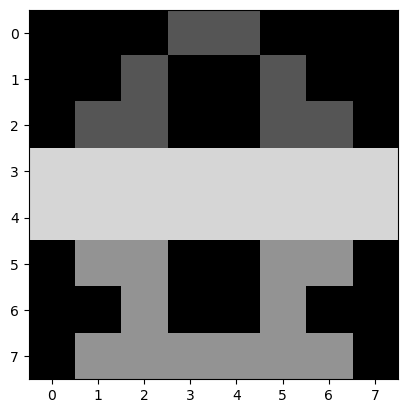

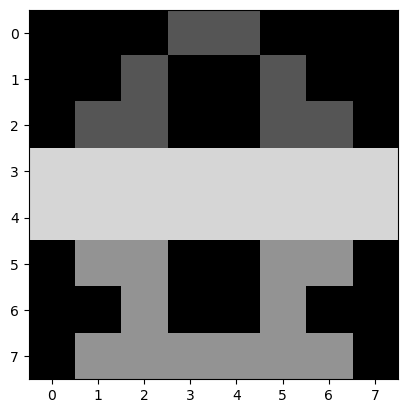

1.0
1.0


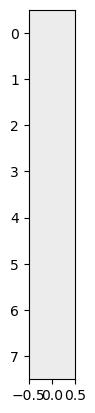

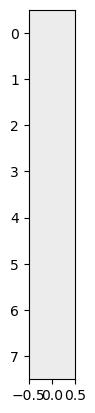

1.0
1.0


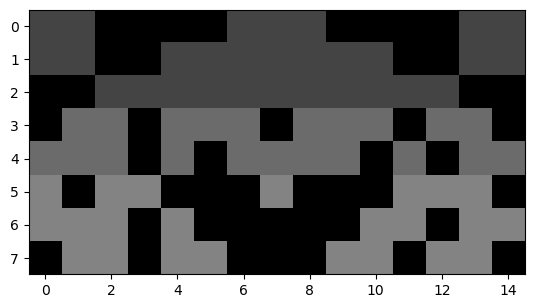

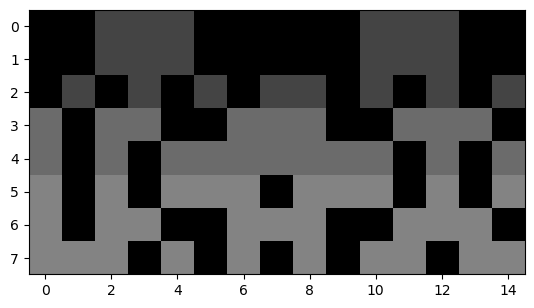

0.31812409288824384
0.31812409288824384


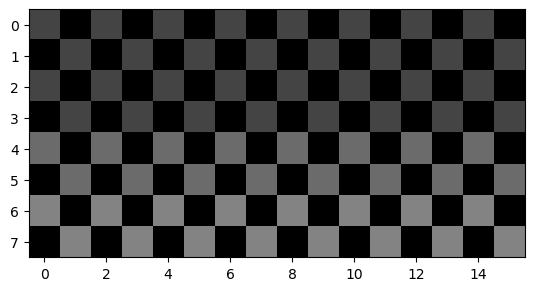

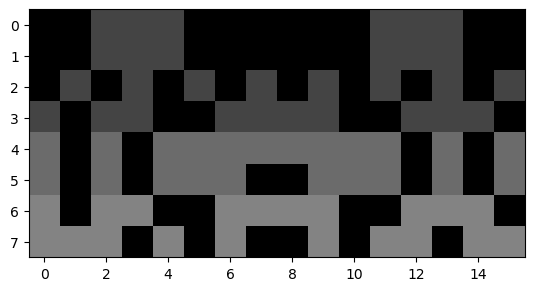

0.32214423761570543
0.32214423761570543


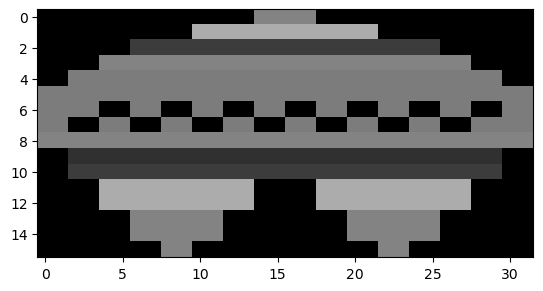

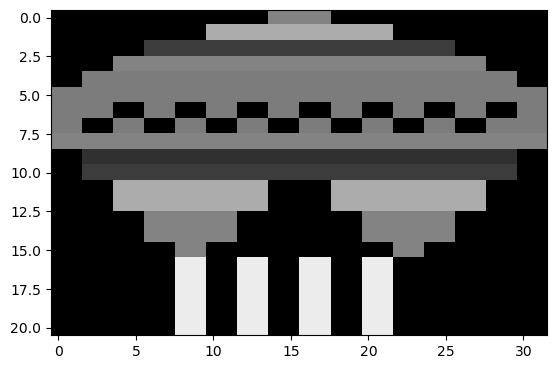

0.7953343161911369
0.7953343161911369


In [ ]:
for key, value in final_matches.items():
    imshow(unhash_obj(key))
    imshow(unhash_obj(value[0]))
    print(get_iou_score(unhash_obj(key), unhash_obj(value[0])))
    #print(value[1])
    #break

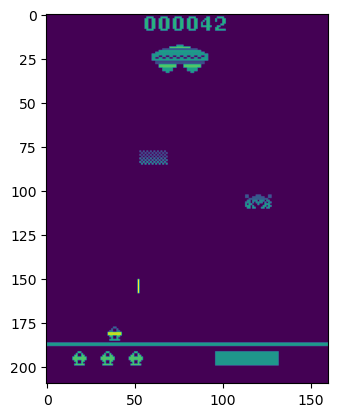

In [30]:
#imshow f1 and f2
plt.imshow(f1)
plt.show()

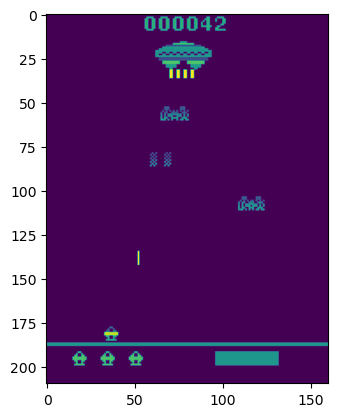

In [31]:
plt.imshow(f2)
plt.show()